In [1]:
try:
    import nqcpfem
except ModuleNotFoundError as err:
    import sys
        # put path to nqcpfem module here   
    src_path = '/mnt/c/Users/swao/nqcp/NQCP_FEM/'
    sys.path.append(src_path)
    import nqcpfem
import sympy
sympy.init_printing(use_latex='mathjax')
import IPython.display as disp
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import logging
LOG = logging.getLogger()
LOG.setLevel(logging.INFO)
from nqcpfem.parameter_search import DBMPParameterSearch, ParameterSearch
from nqcpfem.band_model import LuttingerKohnHamiltonian
from nqcpfem.solvers import PETScSolver
from nqcpfem.envelope_function import RectangleDomain
from nqcpfem.fenics import FEniCsModel
from nqcpfem.g_matrix import GMatrix
from nqcpfem.band_model import __MAGNETIC_FIELD_NAMES__ as _B_
_B_ = sympy.symbols(_B_,commutative=False) # cast to symbols
from nqcpfem.functions import SymbolicFunction




E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev




In [36]:
from nqcpfem.observables import particle_projector,hole_projector

In [28]:

from nqcpfem.systems.dot_sc_dot import *
def syst_init(B=1.75,aspect_ratio=2.1):
    H = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge').add_z_confinement(1,'box',25e-9)
    H.BdG_extension()
    #B = 1.75
    H.add_zeeman_term(B=[B/np.sqrt(2),B/np.sqrt(2),0])
    

    #H.add_potential(-sympy.symbols('\mu'))

    #domain =RectangleDomain(200e-9,100e-9,0)
    #domain.resolution = [150,75]
    from nqcpfem import _hbar,_m_e
    model = FEniCsModel(H,None, boundary_condition=0,function_class=('CG',1))
    omega = 2.5e11 # chosen so that short side of dot is around 50 nm  
    #omega = 5e11 # old code?
    print(omega)
    L_sc = 260e-9
    D_dot = 100e-9
    ldot = Dot(-(D_dot/2 +1e-9+L_sc/2),omega,0,D_dot,aspect_ratio*omega,0,100e-9,)
    rdot = Dot(( D_dot/2+ 1e-9+L_sc/2),aspect_ratio*omega,0,D_dot,omega,0,100e-9,)
    barr = Barrier(0e-9,1000*E0) # 1 meV barrier
    barr = Barrier(0e-9,1000*E0) # 1 meV barrier
    
    ldot = Dot(-(86e-9+L_sc/2),omega,0,150e-9,aspect_ratio*omega,0,150e-9,)
    rdot = Dot((86e-9+L_sc/2),aspect_ratio*omega,0,150e-9,omega,0,150e-9,)
    barr = Barrier(10e-9,1000*E0) # 1 meV barrier
    #rbarr = Barrier(15e-9,3/(nqcpfem.UNIT_CONVENTION['J to eV']*1000))
    sc = Superconductor(100*E0,L_sc,100e-9,0,5*E0)
    syst = DotSCDot(model,ldot,barr,sc,barr,rdot,domain_resolution=[250,100])#[125,50])

    mu,mu_sc = sympy.symbols('\mu,\mu_{sc}')
    mu_R = sympy.symbols('\mu_{R}')
    mu_L = sympy.symbols('\mu_{L}')
    chemical_potential = SymbolicFunction(sympy.Piecewise((-mu_sc,syst.domains['sc_in']),(-mu_L,syst.domains['ld_in']),(-mu_R,syst.domains['rd_in']),(0,True)),'\mu(x)')
    H.add_potential(chemical_potential)

    H.parameter_dict[mu_L] = 0*E0 # will be set to something other than zero on determining couping
    H.parameter_dict[mu_R] = 0*E0 # will be set to something other than zero on determining couping
    H.parameter_dict[mu_sc] = 0

    #minimizations = syst.determine_all_couplings(0,3,solver,425*E0,(-50*E0,50*E0))
    return syst

#syst = syst_init(2) # initialize before to get easier access.

from nqcpfem.solvers import PETScSolver,IterativeSolver
solver = PETScSolver(k=16,which='SM',sigma=0)

def system_update(mu_sc_val,mL,mR,syst=None):
    mu_R = sympy.symbols('\mu_{R}')
    mu,mu_sc = sympy.symbols('\mu,\mu_{sc}')
    mu_L = sympy.symbols('\mu_{L}')
    syst.envelope_model.band_model.parameter_dict[mu_L] = mL
    syst.envelope_model.band_model.parameter_dict[mu_R] = mR
    syst.envelope_model.band_model.parameter_dict[mu_sc] = mu_sc_val
    return syst.envelope_model

first_solver = PETScSolver(k=8,sigma=0,which='SM')
second_solver = PETScSolver(k=8,sigma=0,which='SM',method='GD') # GD uses the the entire subspaces of the previous guess!
second_solver =None
solver = IterativeSolver(first_solver,second_solver)

from nqcpfem.band_model import covariant_sorting
from nqcpfem.majorana import majorana_overlap
def eval_func(model,res):

    try:
        #l_dot,r_dot,sc = syst.__make_system_classes__()
        #X_points = syst.envelope_model.positional_rep(res[1][0])[1]
        #selection=syst.select_subspace((l_dot,r_dot),res[1],4,x_points=X_points) # discard the states in the superconductor as we do not care about them
        
        overlaps = [majorana_overlap(res[1][i],model) for i in range(len(res[0]))]
        
        return res[0],overlaps
    except Exception as err:
        print(err)
        LOGGER.exception(err)
        LOGGER.info(err)
        raise err
        return res[0],None


from nqcpfem.parameter_search import IterativeModelSolver
it_solver = IterativeModelSolver(system_update,solver,eval_func)


In [29]:
model = syst_init()

250000000000.0


In [30]:
fem_model = system_update(4000*E0,4000*E0,4000*E0+27*E0-5*E0,model)

In [31]:
solution = solver.solve(fem_model)

(202808, 202808)


In [32]:
solution[0]/E0

array([   2.61522359+0.j,   -2.61522359+0.j,    3.93262832+0.j,
         -3.93262832+0.j,   18.95069996+0.j,  -18.95069996+0.j,
         20.79861536+0.j,  -20.79861536+0.j,   88.80322353+0.j,
        -88.80322353+0.j,  121.62579624+0.j, -121.62579624+0.j])

In [33]:
np.abs(solution[0][0]-solution[0][1])/E0

5.230447184264157

In [47]:
state_dict = {'pld':0,'hld':1,'prd':2,'hrd':3,'pru':4,'hru':5,'plu':6,'hlu':7}
import pickle as pkl
with open('a_21_b_175_res_250_120.pkl','wb') as f:
    pkl.dump( {k:solution[1][i] for k,i in state_dict.items()},f)

In [42]:
psi = solution[1][6]
nqcpfem.plotting.plot_eigenvector(psi,fem_model)
particle_projector(fem_model.band_model).mel(psi)

INFO:trame_server.controller:trigger(trigger__78)
INFO:trame_server.controller:trigger(trigger__79)
INFO:trame_server.controller:trigger(P_0x7fb28a063c10_11Camera)
INFO:trame_server.controller:trigger(P_0x7fb28a063c10_11AnimateStart)
INFO:trame_server.controller:trigger(P_0x7fb28a063c10_11AnimateStop)
INFO:trame_client.widgets.core:js_key = class
INFO:trame_client.widgets.core:js_key = fluid
INFO:trame_client.widgets.core:js_key = class
INFO:trame_client.widgets.core:before: class = { 'rounded-circle': !P_0x7fb28a063c10_11_show_ui }
INFO:trame_server.utils.namespace:(prefix=None) token {
INFO:trame_server.state:has({ => {) = False
INFO:trame_server.utils.namespace:(prefix=None) token  
INFO:trame_server.state:has(  =>  ) = False
INFO:trame_server.utils.namespace:(prefix=None) token '
INFO:trame_server.state:has(' => ') = False
INFO:trame_server.utils.namespace:(prefix=None) token rounded
INFO:trame_server.state:has(rounded => rounded) = False
INFO:trame_server.utils.namespace:(prefix=N

Widget(value='<iframe src="http://localhost:46863/index.html?ui=P_0x7fb28a063c10_11&reconnect=auto" class="pyv…

0.8841374723256133

In [153]:
from nqcpfem.parameter_search import ParameterSearch
def sweep_func(El):
    fem_model = system_update(4006*E0,4006*E0,4006*E0+25*E0+El,model)
    solution = solver.solve(fem_model)[0]
    return np.abs(solution[0]-solution[1])/E0

El_range= np.linspace(0*E0,15*E0,32)

save = 'T_quicksweep.save'

search = ParameterSearch(El_range,sweep_func,save)
search.run(True,True)


INFO:nqcpfem.parameter_search:evaluating at grid point 1/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 2/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 3/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 4/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 5/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 6/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 7/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 8/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 9/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 10/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 11/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 12/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 13/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 14/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 15/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 16/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 17/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 18/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 19/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 20/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 21/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 22/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 23/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 24/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 25/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 26/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 27/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 28/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 29/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 30/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 31/32


(25704, 25704)


INFO:nqcpfem.parameter_search:evaluating at grid point 32/32


(25704, 25704)


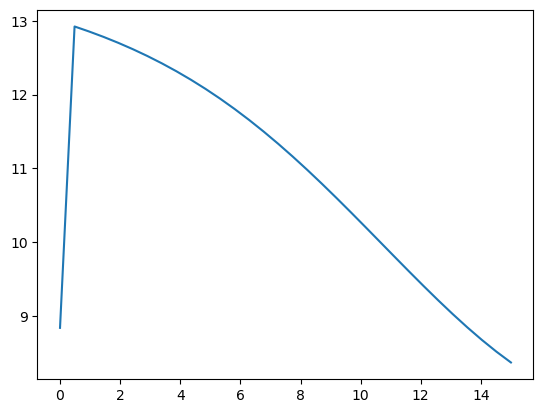

In [154]:
plt.plot(search.parameter_sets/E0,search.results)